# Test 3

This is the third experimental test.

First test will be doubling the speed while maintaining the 1um layer height using all the same things as before. Also changed 'WaitMotionEnd' to 'WaitLogicalMotionEnd' to reduce delay

Second test will use ExtToPointM instead of MultiPointM so we can control end velocity.

Third test will use different heights in the pattern design
- Test different speeds

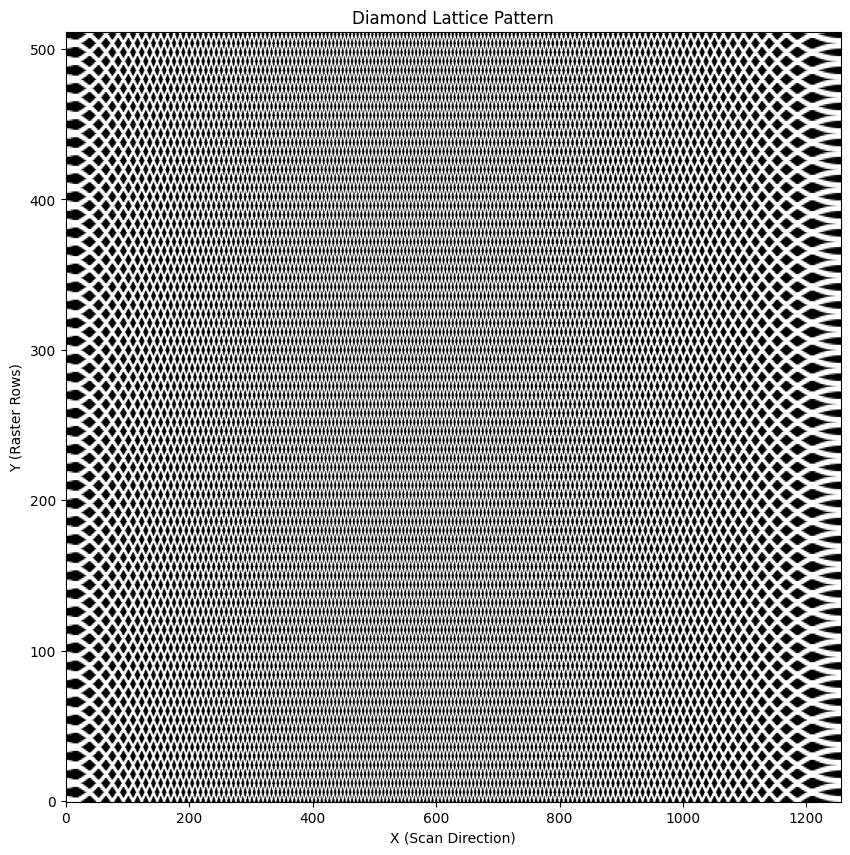

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../nanostride')
import SPiiPlusPython as sp
import pipython
from pipython import GCSDevice

# Settings for printing
sampling_rate = 20_000_000  # 100 MHz

line_duration_us = 157
samples_per_line = sampling_rate * line_duration_us // 2_500_000

# Width and height for viewing purposes
height, width = 512, 1669
pattern = np.zeros((height, width))

# Thicker lines — increase to make lines wider
line_spacing = 12
line_thickness = 4

# Generate diamond lattice pattern
for y in range(height):
    for x in range(width):
        if abs((x + y) % line_spacing) < line_thickness or abs((x - y) % line_spacing) < line_thickness:
            pattern[y, x] = 1.0

# Interpolate each row to match the scan resolution
waveform_rows = []
for row in pattern:
    original_indices = np.linspace(0, 1, width)
    target_indices = np.linspace(0, 1, samples_per_line)
    active_row = np.interp(target_indices, original_indices, row).astype(np.float64)
    waveform_rows.append(active_row)

# Interpolate each row with sinusoidal-like sample redistribution
waveform_rows = []
original_indices = np.linspace(0, 1, width)

# Generate lookup table once — weight more samples to the edges
def generate_nonuniform_indices(n_samples):
    lin = np.linspace(0, 1, n_samples)
    # Weighting more at edges using sine shape (slower scan at edges)
    # This maps uniform time to nonlinear space
    return 0.5 - 0.5 * np.cos(np.pi * lin **0.9) # Smoothly distributes from 0 to 1

target_indices = generate_nonuniform_indices(samples_per_line)

for row in pattern:
    active_row = np.interp(target_indices, original_indices, row).astype(np.float64)
    waveform_rows.append(active_row)

# Show the final pattern visually
plt.figure(figsize=(10, 10))
plt.imshow(waveform_rows, cmap='gray', aspect='auto', origin='lower')
plt.title("Diamond Lattice Pattern")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False)
plt.show()

Motion initialize

In [28]:
pidevice = pipython.GCS2Device("C-887")
pidevice.ConnectRS232(5, 115200)
axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
hc = sp.OpenCommSerial(1, 115200)
sp.DisableAll(hc)
sp.EnableM(hc, [0, 1, -1], sp.SYNCHRONOUS, True)

Same as before but double speed

In [17]:
import nifgen
import time

def set_zero():
    session.output_mode = nifgen.OutputMode.FUNC
    session.configure_standard_waveform(waveform=nifgen.Waveform.DC, amplitude=0, frequency=1, dc_offset=0, start_phase=0.0)
    with session.initiate():
        time.sleep(0.1)

def set_normal():
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000
    session.configure_arb_sequence(sequence_handle, (4.981/2.2), 0)
    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED
    
stage_x = sp.GetTargetPosition(hc, 0, sp.SYNCHRONOUS)
stage_y = sp.GetTargetPosition(hc, 1, sp.SYNCHRONOUS)

axes = [0,1,-1]
sp.MultiPointM(
    hc,
    sp.MotionFlags.ACSC_AMF_VELOCITY,
    axes,
    0,
    failure_check=True
)

with nifgen.Session("Dev1") as session:

    # Set up AWG
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000

    # Create data structures
    waveform_handle_array = []
    loop_counts = []
    for row in waveform_rows:
        waveform_handle_array.append(session._create_waveform_f64_numpy(row))
        loop_counts.append(1)
    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)
    session.configure_arb_sequence(sequence_handle, (4.981/2.2), 0)

    # Set up triggers
    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED

    # Get starting position for hexapod
    hexapod_axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
    hexapod_positions = pidevice.qPOS(hexapod_axes)
    hexapod_z = hexapod_positions['Z']

    # Print parameters
    layers = 200
    y_lims = 0.5
    z_steps = 0.001

    # Initiate -> Move Stage -> Abort -> Move Hexapod -> Initiate
    for i in range(layers):
        set_normal()
        #session.output_enabled = True
        session.initiate()
        print(f"Starting layer {i+1}")
        sp.ExtAddPointM(hc, axes, (stage_x, stage_y+y_lims), 15.82)
        sp.WaitLogicalMotionEnd(hc, sp.Axis.ACSC_AXIS_1, timeout=-1)
        #session.output_enabled = False
        session.abort()
        set_zero()
        print(f"Moving down")
        pidevice.MOV('Z', (hexapod_z - ((i+1)*z_steps)))
        #pidevice.MOV('Z', y_lims)
        while pidevice.IsMoving()['Z']:
            time.sleep(0.01)
        y_lims *= -1
    
    set_zero()

sp.EndSequenceM(hc, axes) # end of multipoint motion
pidevice.CloseConnection()
sp.DisableAll(hc)
sp.CloseComm(hc)


Starting layer 1
Moving down
Starting layer 2
Moving down
Starting layer 3
Moving down
Starting layer 4
Moving down
Starting layer 5
Moving down
Starting layer 6
Moving down
Starting layer 7
Moving down
Starting layer 8
Moving down
Starting layer 9
Moving down
Starting layer 10
Moving down
Starting layer 11
Moving down
Starting layer 12
Moving down
Starting layer 13
Moving down
Starting layer 14
Moving down
Starting layer 15
Moving down
Starting layer 16
Moving down
Starting layer 17
Moving down
Starting layer 18
Moving down
Starting layer 19
Moving down
Starting layer 20
Moving down
Starting layer 21
Moving down
Starting layer 22
Moving down
Starting layer 23
Moving down
Starting layer 24
Moving down
Starting layer 25
Moving down
Starting layer 26
Moving down
Starting layer 27
Moving down
Starting layer 28
Moving down
Starting layer 29
Moving down
Starting layer 30
Moving down
Starting layer 31
Moving down
Starting layer 32
Moving down
Starting layer 33
Moving down
Starting layer 34
M

Test using ExtToPointM and setting end velocity to the same as moving velocity

In [29]:
import nifgen
import time

def set_zero():
    session.output_mode = nifgen.OutputMode.FUNC
    session.configure_standard_waveform(waveform=nifgen.Waveform.DC, amplitude=0, frequency=1, dc_offset=0, start_phase=0.0)
    with session.initiate():
        time.sleep(0.1)

def set_normal():
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000
    session.configure_arb_sequence(sequence_handle, (5.15/2.2), 0)
    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED
    
stage_x = sp.GetTargetPosition(hc, 0, sp.SYNCHRONOUS)
stage_y = sp.GetTargetPosition(hc, 1, sp.SYNCHRONOUS)

axes = [0,1,-1]

with nifgen.Session("Dev1") as session:

    # Set up AWG
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000

    # Create data structures
    waveform_handle_array = []
    loop_counts = []
    for row in waveform_rows:
        waveform_handle_array.append(session._create_waveform_f64_numpy(row))
        loop_counts.append(1)
    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)
    session.configure_arb_sequence(sequence_handle, (5.15/2.2), 0)

    # Set up triggers
    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED

    # Get starting position for hexapod
    hexapod_axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
    hexapod_positions = pidevice.qPOS(hexapod_axes)
    hexapod_z = hexapod_positions['Z']

    # Print parameters
    layers = 250
    y_lims = 1.0
    z_steps = 0.001

    # Initiate -> Move Stage -> Abort -> Move Hexapod -> Initiate
    for i in range(layers):
        set_normal()
        #session.output_enabled = True
        session.initiate()
        print(f"Starting layer {i+1}")
        sp.ExtToPoint(
        hc,
        sp.MotionFlags.ACSC_AMF_VELOCITY | sp.MotionFlags.ACSC_AMF_ENDVELOCITY,
        sp.Axis.ACSC_AXIS_1,
        stage_y+y_lims,
        15.82,
        15.82,
        wait=sp.SYNCHRONOUS,
        failure_check=True
        )
        sp.WaitLogicalMotionEnd(hc, sp.Axis.ACSC_AXIS_1, timeout=-1)
        #session.output_enabled = False
        session.abort()
        set_zero()
        print(f"Moving down")
        pidevice.MOV('Z', (hexapod_z - ((i+1)*z_steps)))
        #pidevice.MOV('Z', y_lims)
        while pidevice.IsMoving()['Z']:
            time.sleep(0.01)
        y_lims *= -1
    
    set_zero()

sp.EndSequenceM(hc, axes) # end of multipoint motion
pidevice.CloseConnection()
sp.DisableAll(hc)
sp.CloseComm(hc)

Starting layer 1
Moving down
Starting layer 2
Moving down
Starting layer 3
Moving down
Starting layer 4
Moving down
Starting layer 5
Moving down
Starting layer 6
Moving down
Starting layer 7
Moving down
Starting layer 8
Moving down
Starting layer 9
Moving down
Starting layer 10
Moving down
Starting layer 11
Moving down
Starting layer 12
Moving down
Starting layer 13
Moving down
Starting layer 14
Moving down
Starting layer 15
Moving down
Starting layer 16
Moving down
Starting layer 17
Moving down
Starting layer 18
Moving down
Starting layer 19
Moving down
Starting layer 20
Moving down
Starting layer 21
Moving down
Starting layer 22
Moving down
Starting layer 23
Moving down
Starting layer 24
Moving down
Starting layer 25
Moving down
Starting layer 26
Moving down
Starting layer 27
Moving down
Starting layer 28
Moving down
Starting layer 29
Moving down
Starting layer 30
Moving down
Starting layer 31
Moving down
Starting layer 32
Moving down
Starting layer 33
Moving down
Starting layer 34
M